In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
# modules
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Analysis

At its core, time series analysis focuses on studying and interpreting a sequence of **data points collected at consistent time intervals**.
Time series data is fundamentally dynamic, evolving over chronological sequences both short and extremely long.
This type of analysis is pivotal in uncovering underlying structures within the data, such as **trends**, **cycles**, and **seasonal variations**.

We can identify three main areas:

1. **Time series data** refers to the raw sequence of observations indexed in time order.

1. **Time series analysis**, the practice of systematically studying this data to identify and model its internal structures such seasonality, trends, and cycles.

1. **Time series forecasting** which uses historical data to make future projections, employing statistical and machine learning models.


# Time Series Data

Time series data are time indexed observations.  As an example we will use the [air passengers data set](https://www.kaggle.com/datasets/chirag19/air-passengers) which provides monthly totals of a US airline passengers from 1949 to 1960.  

Turn the data into a Pandas time serie dataframe.  This allows us to apply Pandas powerful time series tools including the built-in visualization of time series.

In [3]:
# air passenger data
air = pd.read_csv(home+'AirPassengers.csv')
# make the data more amenable to time series analysis with Pandas
air.columns = ['date','passengers']       # rename columns for convenience
air.index = pd.DatetimeIndex(air['date']) # create a time index
air.drop(columns=['date'], inplace=True)  # drop date column, info is now the index
air

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


**Observation**: The index is based on time stamps.

Of course the best way to see the data is to visualize/plot it.

Text(0, 0.5, 'Number of Passengers')

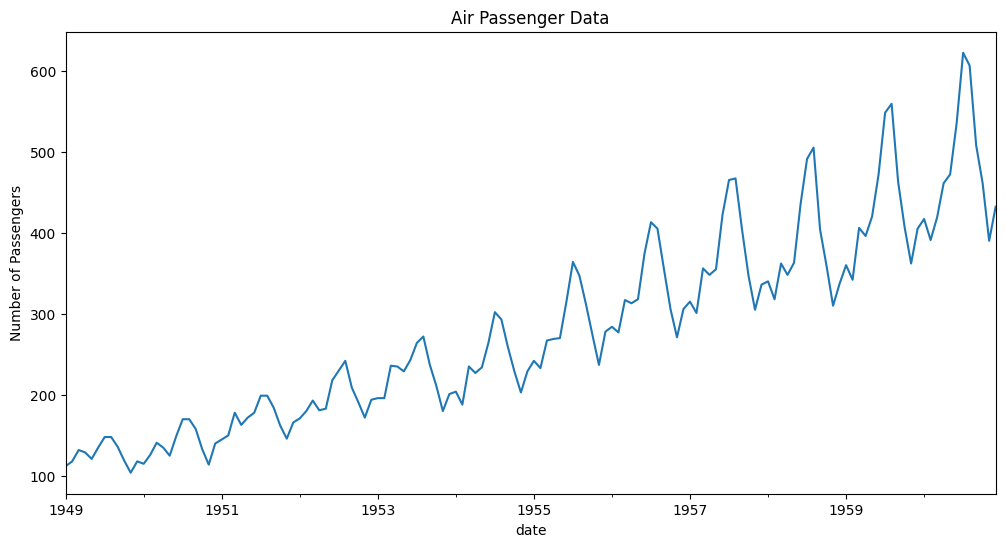

In [4]:
air.plot(figsize=(12,6), title='Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')


Because we used a time based index Pandas knows how to plot this quite nicely.
It is clear from the plot that there is some structure to the time series data.  We can clearly identify a **trend** and **seasonality**.




## Components of Time Series Data


**Trends** show the general direction of the data; whether it is increasing, decreasing, or remaining stationary over an extended period of time. Trends indicate the long-term movement in the data and can reveal overall growth or decline. 

**Seasonality** refers to predictable patterns that recur regularly, like yearly retail spikes during the holiday season. Seasonal components exhibit fluctuations fixed in timing, direction, and magnitude. For instance, electricity usage may surge every summer as people turn on their air conditioners.

**Cycles** demonstrate fluctuations that do not necessarily have a fixed period, such as economic expansions and recessions. These longer-term patterns last longer than a year and do not have consistent amplitudes or durations. Business cycles that oscillate between growth and decline are an example.

**Noise** encompasses the residual variability in the data that the other components cannot explain. Noise includes unpredictable, erratic deviations after accounting for trends, seasonality, and cycles.



### Trend Analysis

Trends are long-term increases, decreases, or stationary movements.
We look at performing trend analysis with rolling windows.

#### Rolling Windows

Rolling windows (or sliding windows) are perhaps the easiest way to visualize trends.  The idea is to define a **time window** of suitable length and use the data points within that window to compute the desired statistic. 
We slide this window one point at a time from start to finish.

Let's try this with our data.  Given that we have monthly data a good window size is probably 12 months.

In [5]:
window_size = 12

Note, the window size is specified in data points.  If we had daily observation then our window size for a year would have to be 365.

We can now apply the `rolling` function to our time index dataframe in order to compute our statistic.  The statistic we chose here is `mean`, that is, we will compute the **average number of passengers within the window**.  This will act like a smoothing function and will remove all seasonal variations.

In [6]:
air_rolling = air\
  .rolling(window=window_size, min_periods=1)\
  .mean()\
  .set_axis(['12m rolling-mean'], axis=1)



Text(0, 0.5, 'Number of Passengers')

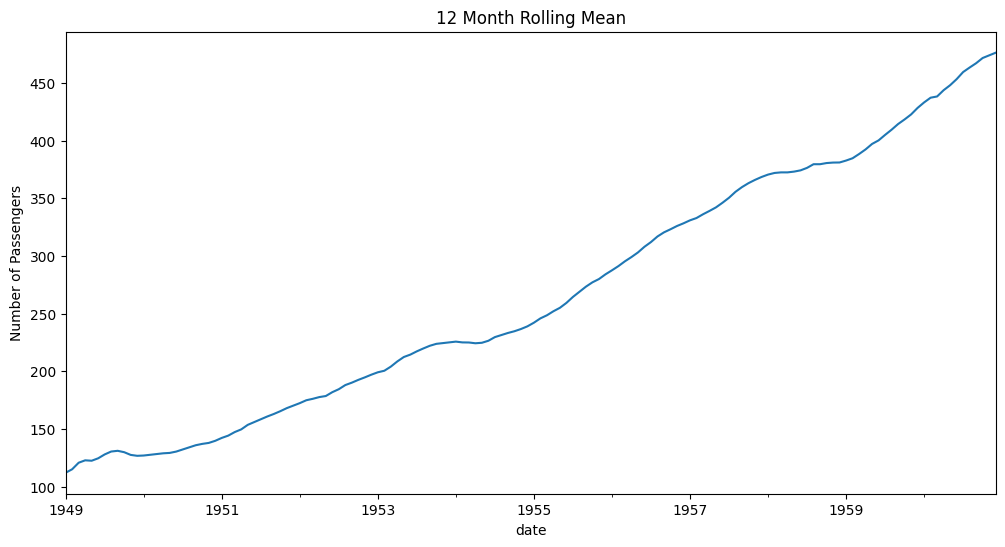

In [7]:
# plot the rolling mean
air_rolling.plot(figsize=(12,6), title='12 Month Rolling Mean', legend=False)\
      .set_ylabel('Number of Passengers')

**Observation**: We obtain an almost linear trend curve.  Interesting to note are the bumps at 1950, 1954, and 1958.  Are those external influences occuring every 4 years?  Presidential elections?  Note that these trend abnormalities were not visible in the original data.  They might be examples of **cycles**.

We can plot the original passenger data and the rolling window data together in one plot.

Text(0, 0.5, 'Number of Passengers')

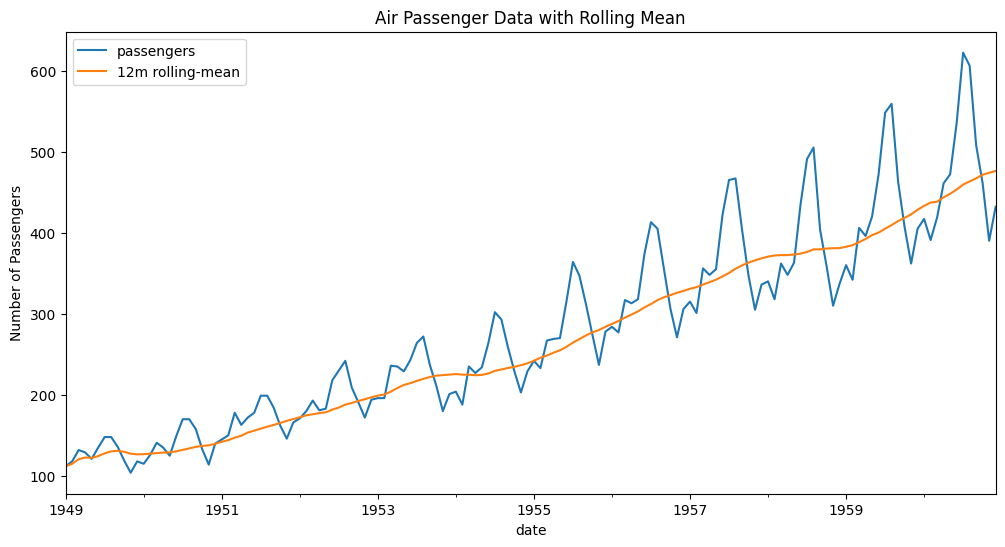

In [8]:
pd.concat([air, air_rolling], axis=1)\
  .plot(title='Air Passenger Data with Rolling Mean', figsize=(12, 6))\
  .set_ylabel('Number of Passengers')

**Observation**: Those three "bumps" in the trend curve are not visible in the original data.

#### The Effect of Window Size

The selection of the rolling window size can have a drastic effect on the quality of the trend plot.  Consider for a moment that we have picked a window size too small, say a **6 months window**.

Text(0, 0.5, 'Number of Passengers')

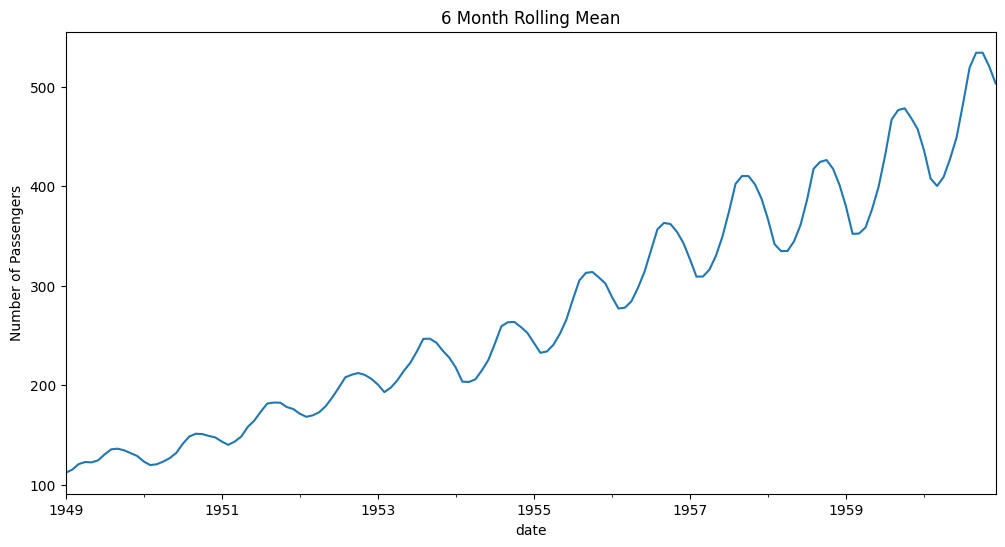

In [9]:
air.rolling(window=6,min_periods=1)\
      .mean()\
      .set_axis(['6m rolling-mean'],axis=1)\
      .plot(figsize=(12,6), title='6 Month Rolling Mean', legend=False)\
      .set_ylabel('Number of Passengers')

Because air travel follows a 12 months seasonality cycle picking a 6 months window allows some of seasonality to show through.

To see what happens if we pick the window too large we pick a **window of 36 months**.

Text(0, 0.5, 'Number of Passengers')

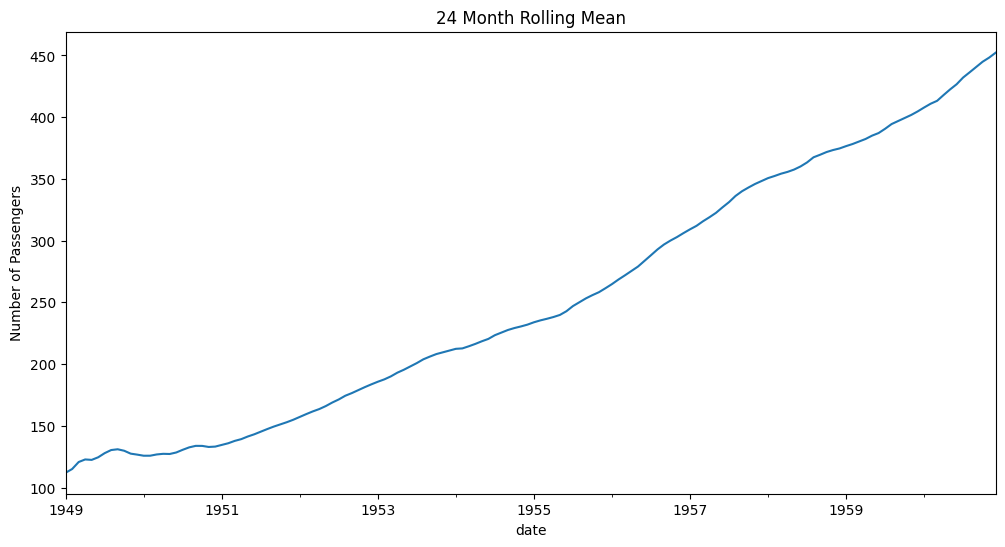

In [10]:
air.rolling(window=24,min_periods=1)\
      .mean()\
      .set_axis(['24m rolling-mean'],axis=1)\
      .plot(figsize=(12,6), title='24 Month Rolling Mean', legend=False)\
      .set_ylabel('Number of Passengers')

Nothing too drastic happens, but some of the finer details of the trend curve are lost.

### Seasonality Analysis

Seasonality analysis hinges on figuring out what kind of time series we are dealing with,

1. **Additive**:  In an additive time series, the components add together to make the time series. This means that if there is an increasing trend, the **peaks and troughs will remain roughly the same size** throughout the time series.  It follows the following additive decomposition,

    <center>

    *data(t) = trend(t) + season(t) + noise(t)*

    </center>

  where t ranges over the time index of the series.

1. **Multiplicative**: In a multiplicative time series, the components multiply together to make the time series. If you have an increasing trend, the amplitude of seasonal activity increases. Everything becomes more exaggerated.
It follows the following multiplicative decomposition,

    <center>

    *data(t) = trend(t) * season(t) * noise(t)*

    </center>

  where t ranges over the time index of the series.


**Let's assume that our time series is additive** and does not have any noise then we can compute the seasonal component as,

<center>

*season(t) = data(t) - trend(t)*

</center>

In [11]:
data = air['passengers']
trend = air_rolling['12m rolling-mean']

In [12]:
# additive decomposition
season = data - trend 

Text(0, 0.5, 'Number of Passengers')

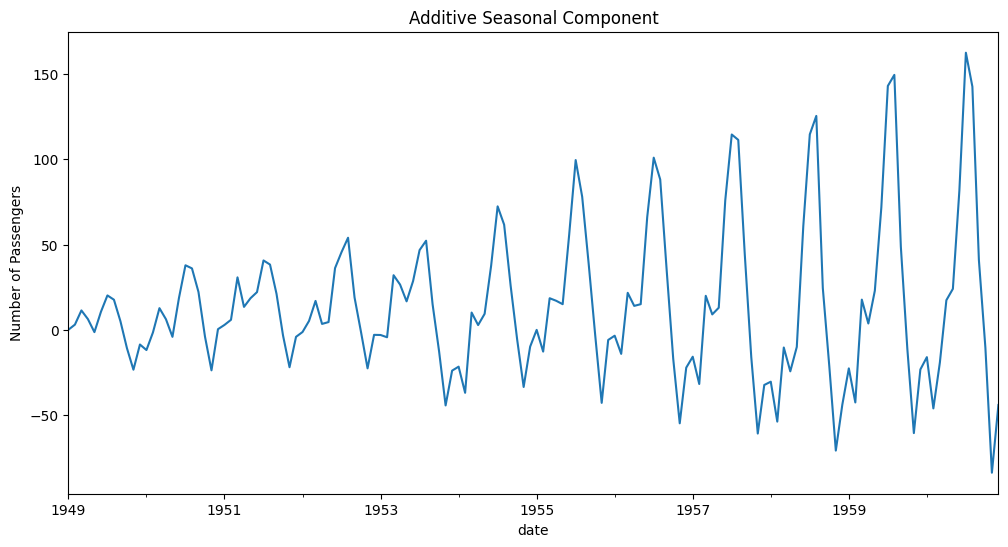

In [13]:
# plot the seasonal component
season.plot(figsize=(12,6), title='Additive Seasonal Component', legend=False)\
      .set_ylabel('Number of Passengers')

**That does not look good, we still have some trend information in the seasonal values.**  That means most likely we are dealing with a multiplicative time series.  

Using the formula for a multiplicative time series and again assuming no noise we can compute the seasonal component as

<center>

*season(t) = data(t) / trend(t)*

</center>

Let's try this,

In [14]:
# multiplicative decomposition
season = data / trend

Text(0, 0.5, 'Number of Passengers')

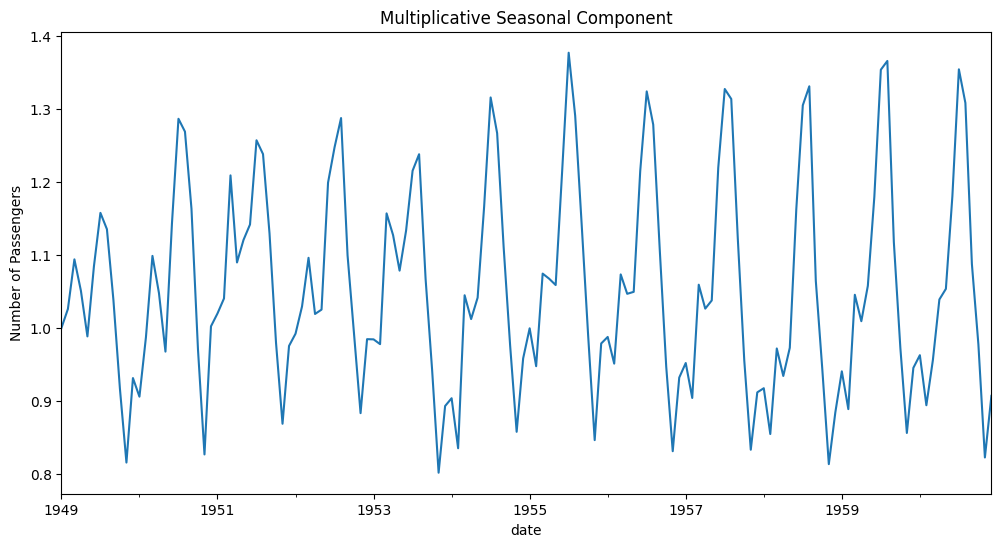

In [15]:
# plot the seasonal component
season.plot(figsize=(12,6), title='Multiplicative Seasonal Component', legend=False)\
      .set_ylabel('Number of Passengers')

**That looks pretty good**, we can clearly see the periods of the activity cycle for the airlines and **no trend information is visible**.

The remaining differences between the seasonal curves is probably noise which we have ignored in our analysis here.

### There is a Module for that

The Python `statsmodels` module has a function that allows use to do this kind of seasonal analysis.  The big difference between our anaylsis and the analysis done by this module is that it also factors out noise in the shape of residuals.

As before, let's try the additive analysis first.

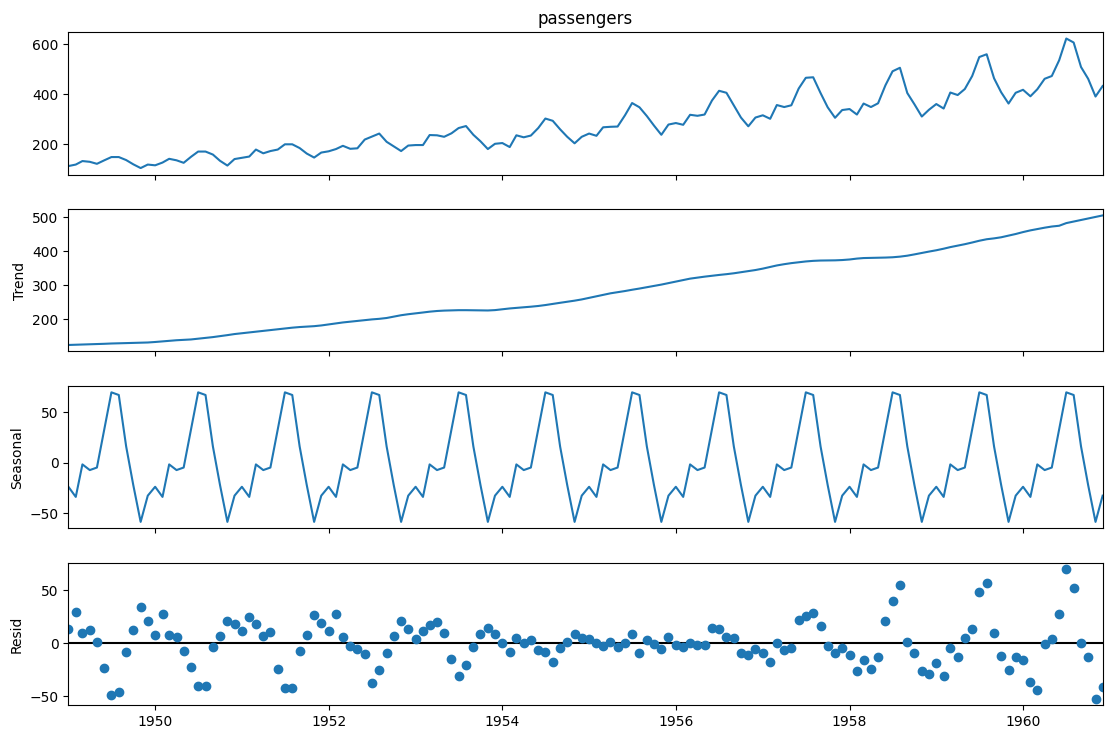

In [16]:
seasonal_decompose(
        air['passengers'],
        model='additive', # 'multiplicative' or 'additive'
        extrapolate_trend = 6 # have to include, centered moving avg
    )\
.plot().set_size_inches(12, 8) # plot the decomposition


**Observation**: The fact that we can observe a **relatively strong signal in the residuals** means that the additive model is not the correct one.  Just as we observed in our previous analysis.

Let's try the multiplicative model.

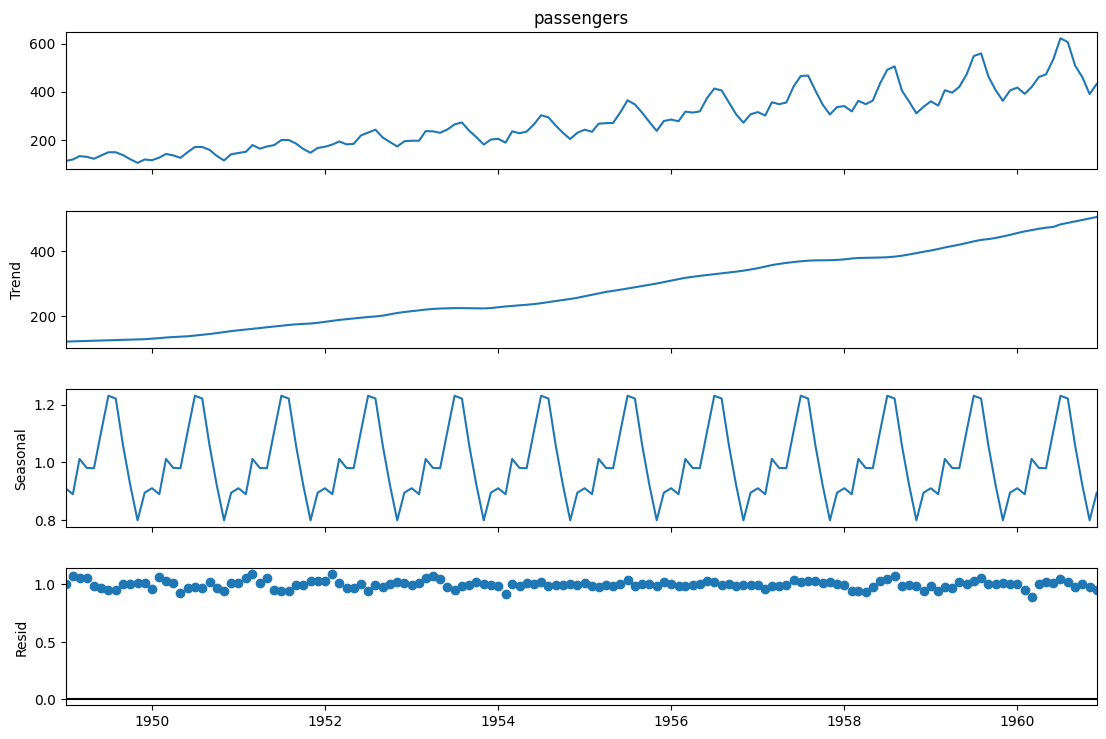

In [17]:
seasonal_decompose(
        air['passengers'],
        model='multiplicative', # 'multiplicative' or 'additive'
        extrapolate_trend = 6 # have to include, centered moving avg
    )\
    .plot().set_size_inches(12, 8) # plot the decomposition


**Observation**: Almost no signal in the residuals.  It roughly the constant 1 being multiplied into the overall signal.

**Observation**: Again we see that our passenger data is multiplicative.

# Reading

* [Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
* [Time Series Analysis Explained](https://www.sigmacomputing.com/resources/learn/what-is-time-series-analysis)
* [Time Series Analysis with ARIMA](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/),
